# 1. use pretrained model
We first show how to load the pre-trained model and use it to make predictions.

First, use a data loader to read the data.

In [1]:
from ASGCNN.Encoder import Graph_data_loader

train_excel =  'data/Train_data_5000.xlsx'
valid_excel = 'data/Valid_data_500.xlsx'
test_excel = 'data/Test_data_500.xlsx'
Encoders_train = ['data/Graph_adsb_train.bin', 'data/Graph_slab_train.bin']
Encoders_valid = ['data/Graph_adsb_valid.bin', 'data/Graph_slab_valid.bin']
Encoders_test = ['data/Graph_adsb_test.bin', 'data/Graph_slab_test.bin']
target = ['Cadsb', 'Csite', 'Gads']

Loader_train = Graph_data_loader(512)
Loader_train.load_data(train_excel, Encoders_train, target=target)
Loader_valid = Graph_data_loader(500)
Loader_valid.load_data(valid_excel, Encoders_valid, target=target)
Loader_test = Graph_data_loader(500)
Loader_test.load_data(test_excel, Encoders_test, target=target)

Then, define the model and load the pre-trained parameters.

In [2]:
from ASGCNN.Model import ASGCNN
from ASGCNN.Trainer import Trainer

Model = ASGCNN(101,6,110,101,8,150,3,[80,120,10],'silu','multy')
t=Trainer(Model, Loader_train, Loader_valid, Loader_test, metric='hyb', metric_para=1-0.662)
t.load_pretrained()

Now, we can get the same prediction as in the paper.

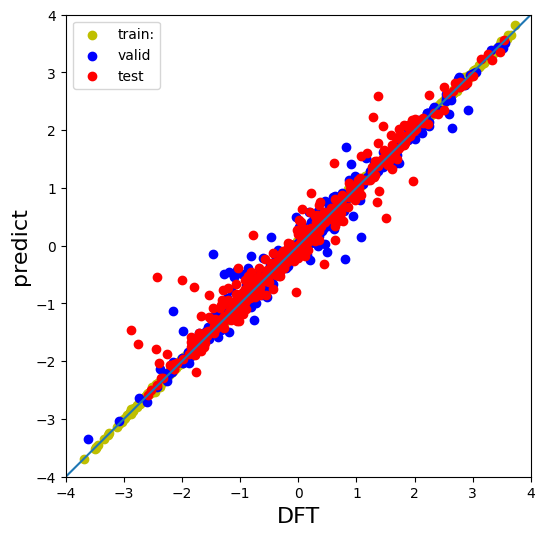

In [3]:
t.show_result()

Finally, we show how to make a prediction on a dataset.

In [4]:
predict, uq = t.predict(Loader_test, to_class=True, return_uq=True)

In [5]:
Loader_test.target[:3]

tensor([[ 0.0000,  0.0000, -0.5184],
        [ 3.0000,  0.0000, -1.3138],
        [ 2.0000,  3.0000, -2.3946]], device='cuda:0')

In [6]:
predict[:3]

array([[ 0.        ,  0.        , -0.5254885 ],
       [ 3.        ,  0.        , -1.31681132],
       [ 2.        ,  3.        , -2.03720593]])

In [7]:
uq[:3]

array([0.02289965, 0.03610388, 0.03876771], dtype=float32)

# 2. train from scratch
Here, we show how to train a network from scratch.

First, an encoder is defined to convert vasp structure files into graphs, one of which adds restriction so that the atoms it grabs are only those at the adsorbed molecules and adsorption sites.

In [8]:
from ASGCNN.Encoder import Encoder_structure
Es_adsb = Encoder_structure(pair_search_method='Voronoi_incell', element_restrict={'N','H'}, element_restrict_mode='atom')
Es_slab = Encoder_structure()

Then, we combine the structure encoder with the graph data loader to load the dataset.

In [9]:
train_excel =  'data/example/Train_6.xlsx'
valid_excel = 'data/example/Valid_3.xlsx'
Encoders = [Es_adsb, Es_slab]
file_paths = ['data/example/structure', 'data/example/structure']
file_columns = ['adsb', 'slab']
target = ['Gads']

Loader_train = Graph_data_loader(3)
Loader_train.load_data(train_excel, Encoders, file_paths, file_columns, target=target)
Loader_valid = Graph_data_loader(3)
Loader_valid.load_data(valid_excel, Encoders, file_paths, file_columns, target=target)

Load graph:   0%|          | 0/12 [00:00<?, ?g/s]

Load graph:   0%|          | 0/6 [00:00<?, ?g/s]

After that, we need to define the feature encoder for the nodes and edges and create corresponding features on the graph.

In [10]:
from ASGCNN.Encoder import Encoder_element, Encoder_edge
Ef_node_slab = Encoder_element(features=['group', 'period', 'electronegativity', 'radius', 'affinity', 'weight'])
Ef_edge_slab = Encoder_edge(features=['category','distance'])
Ef_node_adsb = Encoder_element(features=['group', 'period', 'electronegativity', 'radius', 'density', 'Zeff'])
Ef_edge_adsb = Encoder_edge(features=['category'])

In [11]:
Loader_train.apply_feature([Ef_node_slab, Ef_node_adsb],[Ef_edge_slab, Ef_edge_adsb])
Loader_valid.apply_feature([Ef_node_slab, Ef_node_adsb],[Ef_edge_slab, Ef_edge_adsb])

Apply feature:   0%|          | 0/12 [00:00<?, ?g/s]

Apply feature:   0%|          | 0/6 [00:00<?, ?g/s]

Use the feature_lentgh_total attribute to view the length of features

In [12]:
Ef_node_slab.feature_lentgh_total

60

In [13]:
Ef_edge_slab.feature_length_total

9

In [14]:
Ef_edge_adsb.feature_length_total

3

Finally, we define a new model and trainer to start training

In [15]:
Model = ASGCNN(60,9,60,60,3,40,3,[50,20,10],'silu','regre')
t=Trainer(Model, Loader_train, Loader_valid, init_lr=0.01 , metric='mae')

In [16]:
t.train(10)

Train epoch:   0%|          | 0/10 [00:00<?, ?e/s]